## **Problem Set 2**

Lanz Railey A. Fermin  
5 M DSc  
December 3, 2025

### **0. Preamble**

Import all necessary libraries. Some important notes:
* We use `YOLO` from `ultralytics` as the main model trained in this notebook.
* `albumentations` was used for image augmentation and creation of synthetic dataset from current images-at-hand.

In [99]:
import os
import cv2
import numpy as np
import random
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import json
from ultralytics import YOLO
import albumentations as A
%matplotlib inline

### **1. Setup**

We create the folder structure for synthetic data and define the coin mappings. This step is important as the labels here would serve as the class IDs for YOLO training and value identification.

In [86]:
COINS_DIR = Path("coins_ngsc/cleaned")
OUTPUT_DIR = Path("synth_data")
TRAIN_DIR = OUTPUT_DIR / "train"
VAL_DIR = OUTPUT_DIR / "val"
IMG_SIZE = 256

# Create directories
for split in ['train', 'val']:
    (OUTPUT_DIR / split / 'images').mkdir(parents=True, exist_ok=True)
    (OUTPUT_DIR / split / 'labels').mkdir(parents=True, exist_ok=True)

# Coin class mapping
COIN_CLASSES = {
    '01': 0,
    '05C': 1,
    '05N': 2, 
    '10': 3,   
    '20': 4    
}

COIN_VALUES = {
    0: 1,
    1: 5,
    2: 5,
    3: 10,
    4: 20
}

### **2. Augmentation Pipelines**

Image augmentation is needed so as to make the model learn from a robust set of data. This is done primarily to address the lack of sufficient quantity of images as starting data. The following functions create augmentation steps for the coin photos, which include rotations, flips, brightness, blur, and noise. This would also make the model knowledgeable enough to distinguish coins between different lightings/angles.

We first load the base coin images (obverse/reverse sides), and organizes them by coin type (01, 05C, 05N, 10, 20). Then we apply the augmentation rules defined earlier while preserving transparency since these are .PNG photos.

Afterwards, the following functions were defined: 
* `paste_coin_with_transparency()` places coin on white background
* `check_overlap()` ensures coins don't overlap
* `generate_synthetic_image()` creates full synthetic training image with 1-10 coins

All of these lead to the `generate_dataset()` which is the function that actually initiates the synthetic dataset generation, with its respective YOLO tags.

In [ ]:
def create_coin_augmentation():
    return A.Compose([
        # Geometric transformations
        A.Rotate(limit=360, border_mode=cv2.BORDER_CONSTANT, p=1.0),
        A.HorizontalFlip(p=0.2),
        A.VerticalFlip(p=0.2),

        # Color/intensity transformations
        A.RandomGamma(gamma_limit=(70, 130), p=0.45),
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.6, contrast_limit=0.6, p=0.5),
        
        # Noise
        A.GaussNoise(var_limit=(5, 25), p=0.4),
        A.OneOf([A.MotionBlur(blur_limit=5, p=1), A.GaussianBlur(blur_limit=5, p=1)], p=0.3),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
    ])

coin_augmenter = create_coin_augmentation()

C:\Users\Lanz Railey Fermin\AppData\Local\Temp\ipykernel_1904\372616713.py:16: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5, 25), p=0.4),


In [88]:
def load_coin_images():
    coin_images = {}
    
    for coin_file in COINS_DIR.glob("*.png"):
        filename = coin_file.stem

        coin_code = None
        for code in COIN_CLASSES.keys():
            if filename.startswith(code):
                coin_code = code
                break
        
        if coin_code is None:
            continue
        
        side = 'obverse' if 'obverse' in filename.lower() else 'reverse'
        img = cv2.imread(str(coin_file), cv2.IMREAD_UNCHANGED)
        
        if coin_code not in coin_images:
            coin_images[coin_code] = {'obverse': None, 'reverse': None}
        
        coin_images[coin_code][side] = img
    
    return coin_images

coin_images = load_coin_images()
print(f"Loaded coins: {list(coin_images.keys())}")

Loaded coins: ['01', '05C', '05N', '10', '20']


In [ ]:
def augment_coin(coin_img, augmenter):
    # Separate RGB and Alpha channels
    if coin_img.shape[2] == 4:
        rgb = coin_img[:, :, :3]
        alpha = coin_img[:, :, 3]
    else:
        rgb = coin_img
        alpha = np.ones((coin_img.shape[0], coin_img.shape[1]), dtype=np.uint8) * 255
    
    # Apply augmentation to RGB only
    augmented = augmenter(image=rgb)
    rgb_aug = augmented['image']
    
    # Recombine with alpha channel
    result = np.dstack([rgb_aug, alpha])
    return result

In [ ]:
def paste_coin_with_transparency(background, coin_img, x, y, scale=1.0):
    # Resize coin while maintaining aspect ratio
    h, w = coin_img.shape[:2]
    new_w, new_h = int(w * scale), int(h * scale)
    
    # Ensure coin fits within image boundaries
    max_dim = max(new_w, new_h)
    if max_dim > IMG_SIZE * 0.4:  # Limit max size to 40% of image
        resize_factor = (IMG_SIZE * 0.4) / max_dim
        new_w = int(new_w * resize_factor)
        new_h = int(new_h * resize_factor)
    
    coin_resized = cv2.resize(coin_img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Calculate position (center-based)
    x1 = x - new_w // 2
    y1 = y - new_h // 2
    x2 = x1 + new_w
    y2 = y1 + new_h
    
    # Check if coin goes out of bounds - reject if it does
    if x1 < 0 or y1 < 0 or x2 > IMG_SIZE or y2 > IMG_SIZE:
        return background, None
    
    if coin_resized.shape[2] == 4:
        alpha = coin_resized[:, :, 3] / 255.0
        coin_rgb = coin_resized[:, :, :3]
    else:
        alpha = np.ones((new_h, new_w))
        coin_rgb = coin_resized
    
    roi = background[y1:y2, x1:x2]
    for c in range(3):
        roi[:, :, c] = alpha * coin_rgb[:, :, c] + (1 - alpha) * roi[:, :, c]
    
    background[y1:y2, x1:x2] = roi
    
    # Return bounding box (normalized)
    bbox = {
        'x_center': x / IMG_SIZE,
        'y_center': y / IMG_SIZE,
        'width': new_w / IMG_SIZE,
        'height': new_h / IMG_SIZE
    }
    
    return background, bbox

def check_overlap(new_bbox, existing_bboxes):
    nx1 = (new_bbox['x_center'] - new_bbox['width'] / 2) * IMG_SIZE
    ny1 = (new_bbox['y_center'] - new_bbox['height'] / 2) * IMG_SIZE
    nx2 = (new_bbox['x_center'] + new_bbox['width'] / 2) * IMG_SIZE
    ny2 = (new_bbox['y_center'] + new_bbox['height'] / 2) * IMG_SIZE
    
    for bbox in existing_bboxes:
        ex1 = (bbox['x_center'] - bbox['width'] / 2) * IMG_SIZE
        ey1 = (bbox['y_center'] - bbox['height'] / 2) * IMG_SIZE
        ex2 = (bbox['x_center'] + bbox['width'] / 2) * IMG_SIZE
        ey2 = (bbox['y_center'] + bbox['height'] / 2) * IMG_SIZE
        
        # Check if rectangles overlap
        if not (nx2 < ex1 or nx1 > ex2 or ny2 < ey1 or ny1 > ey2):
            return True
    
    return False

def generate_synthetic_image(coin_images, augmenter, num_coins=None):
    background = np.ones((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8) * 255
    
    # Random number of coins (1-10)
    if num_coins is None:
        num_coins = random.randint(1, 10)
    
    annotations = []
    bboxes = []
    
    max_attempts = 100
    placed_coins = 0
    
    while placed_coins < num_coins and max_attempts > 0:
        # Random coin type
        coin_code = random.choice(list(coin_images.keys()))
        class_id = COIN_CLASSES[coin_code]
        
        # Random side
        side = random.choice(['obverse', 'reverse'])
        coin_img = coin_images[coin_code][side]
        
        if coin_img is None:
            max_attempts -= 1
            continue

        coin_img_aug = augment_coin(coin_img, augmenter)
        
        # Random scale (0.3x to 1.2x)
        scale = random.uniform(0.3, 1.2)
        
        # Get coin dimensions after scaling
        h, w = coin_img_aug.shape[:2]
        scaled_w = int(w * scale)
        scaled_h = int(h * scale)
        
        # Limit max dimension
        max_dim = max(scaled_w, scaled_h)
        if max_dim > IMG_SIZE * 0.4:
            resize_factor = (IMG_SIZE * 0.4) / max_dim
            scaled_w = int(scaled_w * resize_factor)
            scaled_h = int(scaled_h * resize_factor)
            scale = scale * resize_factor
        
        # Random position - ensure coin stays within boundaries
        margin_x = scaled_w // 2
        margin_y = scaled_h // 2
        x = random.randint(margin_x, IMG_SIZE - margin_x)
        y = random.randint(margin_y, IMG_SIZE - margin_y)
        
        # Paste coin
        background_copy = background.copy()
        background_temp, bbox = paste_coin_with_transparency(background_copy, coin_img_aug, x, y, scale)
        
        if bbox is None:
            max_attempts -= 1
            continue
        
        # Check for overlap
        if check_overlap(bbox, bboxes):
            max_attempts -= 1
            continue
        
        # Accept placement
        background = background_temp
        bboxes.append(bbox)
        annotations.append({
            'class_id': class_id,
            'bbox': bbox
        })
        placed_coins += 1
    
    return background, annotations

def generate_dataset(num_train=1000, num_val=200):
    print("Generating training data...")
    for i in range(num_train):
        img, annotations = generate_synthetic_image(coin_images, coin_augmenter)
        
        # Save image
        img_path = TRAIN_DIR / 'images' / f'train_{i:04d}.jpg'
        cv2.imwrite(str(img_path), img)
        
        # Save YOLO format labels
        label_path = TRAIN_DIR / 'labels' / f'train_{i:04d}.txt'
        with open(label_path, 'w') as f:
            for ann in annotations:
                bbox = ann['bbox']
                f.write(f"{ann['class_id']} {bbox['x_center']:.6f} {bbox['y_center']:.6f} {bbox['width']:.6f} {bbox['height']:.6f}\n")
        
        if (i + 1) % 100 == 0:
            print(f"Generated {i + 1}/{num_train} training images")
    
    print("\nGenerating validation data...")
    for i in range(num_val):
        img, annotations = generate_synthetic_image(coin_images, coin_augmenter)
        
        img_path = VAL_DIR / 'images' / f'val_{i:04d}.jpg'
        cv2.imwrite(str(img_path), img)
        
        label_path = VAL_DIR / 'labels' / f'val_{i:04d}.txt'
        with open(label_path, 'w') as f:
            for ann in annotations:
                bbox = ann['bbox']
                f.write(f"{ann['class_id']} {bbox['x_center']:.6f} {bbox['y_center']:.6f} {bbox['width']:.6f} {bbox['height']:.6f}\n")
        
        if (i + 1) % 50 == 0:
            print(f"Generated {i + 1}/{num_val} validation images")
    
    print("\nDataset generation complete!")

generate_dataset(num_train=400, num_val=100)


Generating training data...
Generated 100/400 training images
Generated 200/400 training images
Generated 300/400 training images
Generated 400/400 training images

Generating validation data...
Generated 50/100 validation images
Generated 100/100 validation images

Dataset generation complete!


### **3. YOLOv8 Configurations**

In this section, we proceed by initializing the YOLOv8 model that we need to train. We create a YAML file to tell the model where to find the train/val data, and define the five coin classes. Afterwards, we train the YOLOv8 Nano model using the synthetic data on 50 epochs, batch size 16, with early stopping. Evaluation of the model followed thereafter.

In [ ]:
def create_dataset_yaml():
    yaml_content = f"""
path: {OUTPUT_DIR.absolute()}
train: train/images
val: val/images

nc: 5
names: ['1 peso', '5 peso circle', '5 peso nonagon', '10 peso', '20 peso']
"""
    
    yaml_path = OUTPUT_DIR / 'dataset.yaml'
    with open(yaml_path, 'w') as f:
        f.write(yaml_content.strip())
    
    print(f"Created dataset.yaml at {yaml_path}")
    return yaml_path

yaml_path = create_dataset_yaml()

Created dataset.yaml at synth_data\dataset.yaml


In [ ]:
def train_yolo_model(epochs, img_size=256, batch_size=16):
    # Initialize YOLOv8 nano model
    model = YOLO('yolov8n.pt')
    
    # Train the model
    results = model.train(
        data=str(yaml_path),
        epochs=epochs,
        imgsz=img_size,
        batch=batch_size,
        name='coin_detector',
        patience=3,  # Early stopping
        save=True,
        device='cpu',
        plots=True
    )
    
    return model, results

# Train the model
print("Starting YOLOv8 training...")
model, results = train_yolo_model(epochs=50)
print("Training complete!")

Starting YOLOv8 training...
Ultralytics 8.3.234  Python-3.13.7 torch-2.9.1+cpu CPU (11th Gen Intel Core i7-1165G7 @ 2.80GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=synth_data\dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=coin_detector, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patie

In [ ]:
def evaluate_model(model):
    metrics = model.val()
    
    print("\n=== Validation Metrics ===")
    print(f"mAP50: {metrics.box.map50:.4f}")
    print(f"mAP50-95: {metrics.box.map:.4f}")
    print(f"Precision: {metrics.box.mp:.4f}")
    print(f"Recall: {metrics.box.mr:.4f}")
    
    return metrics

metrics = evaluate_model(model)

Ultralytics 8.3.234  Python-3.13.7 torch-2.9.1+cpu CPU (11th Gen Intel Core i7-1165G7 @ 2.80GHz)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 104.742.6 MB/s, size: 17.0 KB)
val: Scanning C:\Users\Lanz Railey Fermin\Desktop\projects\ma282_coins\synth_data\val\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 87.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.9it/s 3.7s0.6s
                   all        100        248      0.958      0.962      0.992      0.985
                1 peso         38         43      0.923          1      0.993      0.993
         5 peso circle         43         48      0.912          1      0.994       0.99
        5 peso nonagon         42         52      0.981      0.997      0.994      0.981
               10 peso         50         64      0.974      0.953      0.994 

### **4. Detection and Visualization Functions**

We define some important functions to help us visualize the predictions made by the model after training.
* `detect_and_calculate_value()` runs inference, calculates total peso value
* `visualize_detection()` draws bounding boxes, shows image, prints breakdown
* `test_custom_image()` is a wrapper function for easy one-shot testing

In [ ]:
def detect_and_calculate_value(model, image_path, conf_threshold=0.25):
    """
    Detect coins in image and calculate total value
    
    Args:
        model: Trained YOLO model
        image_path: Path to image
        conf_threshold: Confidence threshold for detections
    
    Returns:
        total_value: Total monetary value
        detections: List of detected coins with values
    """
    # Run inference
    results = model.predict(image_path, conf=conf_threshold, verbose=False)
    
    detections = []
    total_value = 0
    
    for result in results:
        boxes = result.boxes
        for box in boxes:
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            bbox = box.xyxy[0].cpu().numpy()  # x1, y1, x2, y2
            
            coin_value = COIN_VALUES[class_id]
            total_value += coin_value
            
            detections.append({
                'class_id': class_id,
                'class_name': list(COIN_CLASSES.keys())[class_id],
                'value': coin_value,
                'confidence': confidence,
                'bbox': bbox
            })
    
    return total_value, detections

def visualize_detection(image_path, model, conf_threshold=0.25):
    # Read image
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get detections
    total_value, detections = detect_and_calculate_value(model, image_path, conf_threshold)
    
    # Plot
    plt.figure(figsize=(12, 12))
    plt.imshow(img_rgb)
    
    # Draw bounding boxes
    for det in detections:
        bbox = det['bbox']
        x1, y1, x2, y2 = bbox
        
        # Draw rectangle
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                            fill=False, edgecolor='lime', linewidth=3)
        plt.gca().add_patch(rect)
        
        # Add label
        label = f"₱{det['value']} ({det['confidence']:.2f})"
        plt.text(x1, y1 - 10, label,
                color='lime', fontsize=12, weight='bold',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
    plt.title(f'Detected Coins - Total Value: ₱{total_value}', fontsize=16, weight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal Value: ₱{total_value}")
    print(f"Number of coins detected: {len(detections)}")
    print("\nDetailed breakdown:")
    for i, det in enumerate(detections, 1):
        print(f"  {i}. {det['class_name']}: ₱{det['value']} (confidence: {det['confidence']:.2f})")
    
    return total_value, detections

# Test on validation images
print("Testing on validation images...")
for i in range(3):
    img_path = VAL_DIR / 'images' / f'val_{i:04d}.jpg'
    visualize_detection(img_path, model, conf_threshold=0.5)

Testing on validation images...


<Figure size 1200x1200 with 1 Axes>


Total Value: ₱10
Number of coins detected: 2

Detailed breakdown:
  1. 05N: ₱5 (confidence: 0.99)
  2. 05N: ₱5 (confidence: 0.97)


<Figure size 1200x1200 with 1 Axes>


Total Value: ₱5
Number of coins detected: 1

Detailed breakdown:
  1. 05N: ₱5 (confidence: 0.98)


<Figure size 1200x1200 with 1 Axes>


Total Value: ₱15
Number of coins detected: 2

Detailed breakdown:
  1. 10: ₱10 (confidence: 1.00)
  2. 05N: ₱5 (confidence: 0.99)


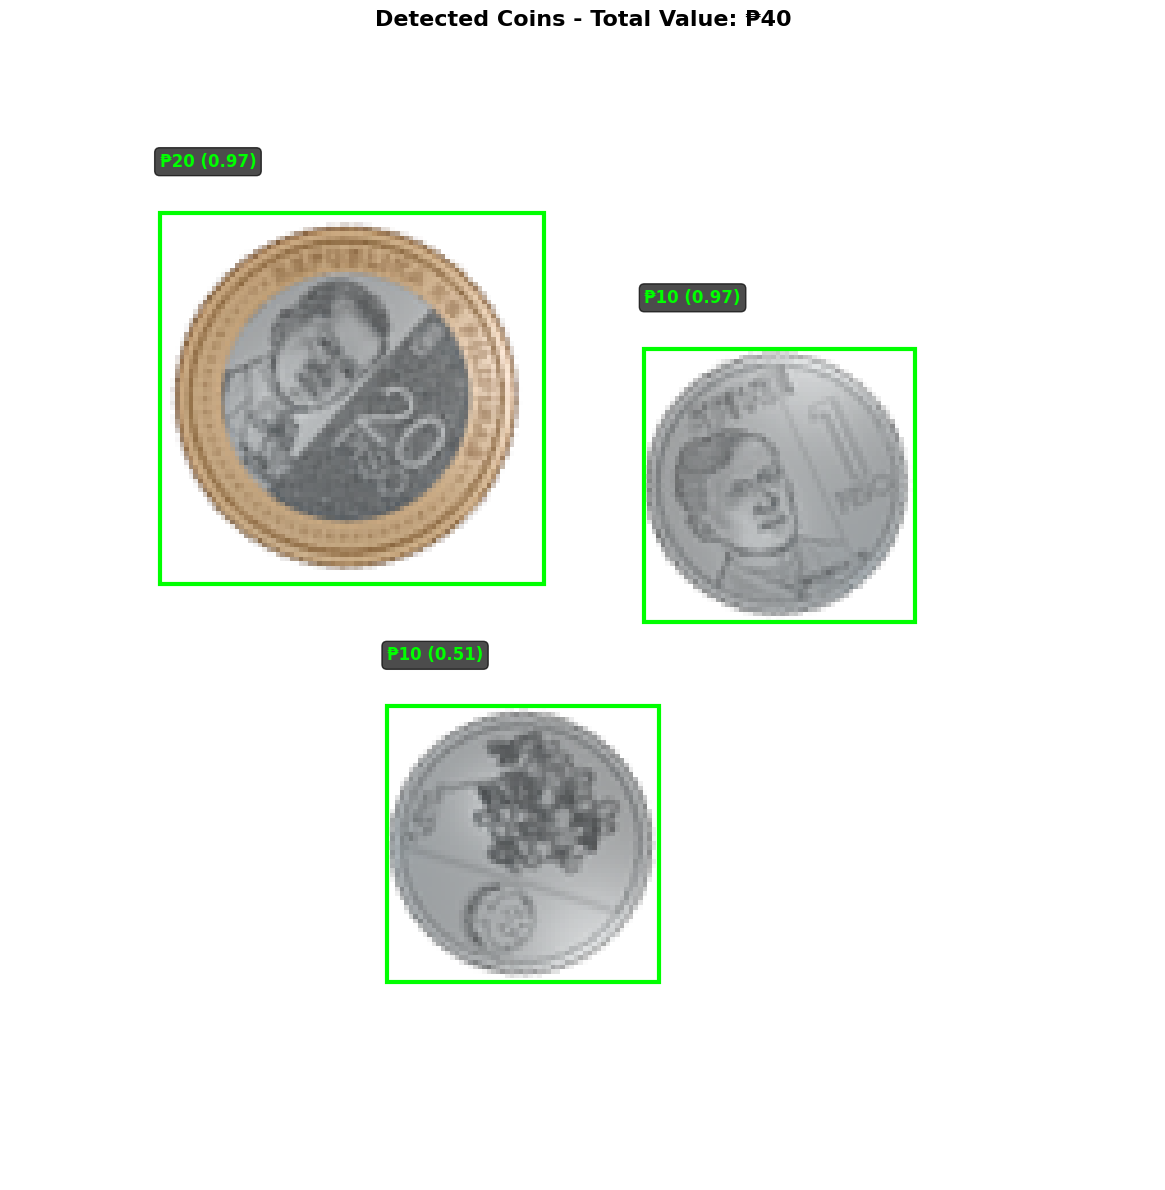


Total Value: ₱40
Number of coins detected: 3

Detailed breakdown:
  1. 10: ₱10 (confidence: 0.97)
  2. 20: ₱20 (confidence: 0.97)
  3. 10: ₱10 (confidence: 0.51)


In [ ]:
def test_custom_image(model, image_path):
    """Test model on a custom image"""
    if not Path(image_path).exists():
        print(f"Error: Image not found at {image_path}")
        return
    
    total_value, detections = visualize_detection(image_path, model, conf_threshold=0.5)

test_custom_image(model, "coins_ngsc/testings/15.PNG")

### **5. Further Augmentation and Model Retraining**

I noticed that the model performed poorly on vector images and rotations. So, I figured that it would be prudent to retrain and add more training data that focuses on using vector images and its transformations. I re-did the augmentation pipeline earlier, but with some modifications, and created more aggressive augmentation. After generation, the model was retrained from scratch and re-evaluated.

In [ ]:
# Section 13: Load VECTOR Coin Images
def load_vector_coin_images():
    """Load VECTOR versions of coins (high-quality renders)"""
    vector_coin_images = {}
    
    for coin_file in COINS_DIR.glob("*_VECTOR*.png"):
        filename = coin_file.stem
        
        coin_code = None
        for code in COIN_CLASSES.keys():
            if filename.startswith(code):
                coin_code = code
                break
        
        if coin_code is None:
            continue
        
        side = 'obverse' if 'obverse' in filename.lower() else 'reverse'
        img = cv2.imread(str(coin_file), cv2.IMREAD_UNCHANGED)
        
        if coin_code not in vector_coin_images:
            vector_coin_images[coin_code] = {'obverse': None, 'reverse': None}
        
        vector_coin_images[coin_code][side] = img
    
    return vector_coin_images

vector_coin_images = load_vector_coin_images()
print(f"Loaded VECTOR coins: {list(vector_coin_images.keys())}")
print(f"Number of VECTOR coin types: {len(vector_coin_images)}")

def create_vector_augmentation():
    return A.Compose([
        # Geometric
        A.Rotate(limit=360, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0), p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        
        # Heavy lighting variation
        A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=0.8),
        A.RandomGamma(gamma_limit=(60, 140), p=0.6),
        A.CLAHE(clip_limit=3.0, tile_grid_size=(8, 8), p=0.5),
        
        # Noise
        A.GaussNoise(var_limit=(10.0, 40.0), mean=0, p=0.6),
        
        # Blurs
        A.OneOf([
            A.MotionBlur(blur_limit=7, p=1.0),
            A.GaussianBlur(blur_limit=7, p=1.0),
            A.MedianBlur(blur_limit=7, p=1.0),
        ], p=0.5),
        
        # Color temperature variation
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=0.4),
    ])

vector_augmenter = create_vector_augmentation()

Loaded VECTOR coins: ['01', '05N', '10', '20']
Number of VECTOR coin types: 4


C:\Users\Lanz Railey Fermin\AppData\Local\Temp\ipykernel_1904\3030680866.py:40: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(limit=360, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0), p=1.0),
C:\Users\Lanz Railey Fermin\AppData\Local\Temp\ipykernel_1904\3030680866.py:50: UserWarning: Argument(s) 'var_limit, mean' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 40.0), mean=0, p=0.6),


In [ ]:
def generate_mixed_dataset(num_train=500, num_val=100, vector_ratio=0.5, start_idx_train=None, start_idx_val=None):

    # Auto-detect starting indices
    if start_idx_train is None:
        start_idx_train = len(list((TRAIN_DIR / 'images').glob('*.jpg')))
    if start_idx_val is None:
        start_idx_val = len(list((VAL_DIR / 'images').glob('*.jpg')))
    
    print("Generating MIXED training data (Regular + VECTOR)...")
    for i in range(num_train):
        if random.random() < vector_ratio and len(vector_coin_images) > 0:
            img, annotations = generate_synthetic_image(vector_coin_images, vector_augmenter)
        else:
            img, annotations = generate_synthetic_image(coin_images, coin_augmenter)
        
        img_idx = start_idx_train + i
        img_path = TRAIN_DIR / 'images' / f'train_{img_idx:04d}.jpg'
        cv2.imwrite(str(img_path), img)
        
        label_path = TRAIN_DIR / 'labels' / f'train_{img_idx:04d}.txt'
        with open(label_path, 'w') as f:
            for ann in annotations:
                bbox = ann['bbox']
                f.write(f"{ann['class_id']} {bbox['x_center']:.6f} {bbox['y_center']:.6f} {bbox['width']:.6f} {bbox['height']:.6f}\n")
        
        if (i + 1) % 100 == 0:
            print(f"Generated {i + 1}/{num_train} mixed training images")
    
    print("\nGenerating MIXED validation data...")
    for i in range(num_val):
        if random.random() < vector_ratio and len(vector_coin_images) > 0:
            img, annotations = generate_synthetic_image(vector_coin_images, vector_augmenter)
        else:
            img, annotations = generate_synthetic_image(coin_images, coin_augmenter)
        
        img_idx = start_idx_val + i
        img_path = VAL_DIR / 'images' / f'val_{img_idx:04d}.jpg'
        cv2.imwrite(str(img_path), img)
        
        label_path = VAL_DIR / 'labels' / f'val_{img_idx:04d}.txt'
        with open(label_path, 'w') as f:
            for ann in annotations:
                bbox = ann['bbox']
                f.write(f"{ann['class_id']} {bbox['x_center']:.6f} {bbox['y_center']:.6f} {bbox['width']:.6f} {bbox['height']:.6f}\n")
        
        if (i + 1) % 50 == 0:
            print(f"Generated {i + 1}/{num_val} mixed validation images")
    
    total_train = start_idx_train + num_train
    total_val = start_idx_val + num_val
    print(f"\nMixed dataset generation complete!")
    print(f"Total training images: {total_train}")
    print(f"Total validation images: {total_val}")

generate_mixed_dataset(
    num_train=400, 
    num_val=100, 
    vector_ratio=0.8  # 80% Vector coins
)

Generating MIXED training data (Regular + VECTOR)...
Generated 100/400 mixed training images
Generated 200/400 mixed training images
Generated 300/400 mixed training images
Generated 400/400 mixed training images

Generating MIXED validation data...
Generated 50/100 mixed validation images
Generated 100/100 mixed validation images

Mixed dataset generation complete!
Total training images: 804
Total validation images: 201


In [ ]:
def retrain_yolo_model(epochs=50, img_size=256, batch_size=16, resume=False):
    if resume:
        model = YOLO('runs/detect/coin_detector/weights/last.pt')
        print("Resuming from last checkpoint...")
    else:
        model = YOLO('yolov8n.pt')
        print("Starting fresh training with pretrained weights...")
    
    results = model.train(
        data=str(yaml_path),
        epochs=epochs,
        imgsz=img_size,
        batch=batch_size,
        name='coin_detector_v2',
        patience=5,
        save=True,
        device='cpu',
        plots=True
    )
    
    return model, results

print("Retraining with expanded dataset...")
model_v2, results_v2 = retrain_yolo_model(epochs=50, resume=False)
print("Retraining complete!")

Retraining with expanded dataset...
Starting fresh training with pretrained weights...
Ultralytics 8.3.234  Python-3.13.7 torch-2.9.1+cpu CPU (11th Gen Intel Core i7-1165G7 @ 2.80GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=synth_data\dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=coin_detector_v2, nbs=64, nms=False, opset=

In [ ]:
print("Evaluating retrained model on validation set...")
metrics_v2 = model_v2.val()

print("\n=== Retrained Model Metrics ===")
print(f"mAP50: {metrics_v2.box.map50:.4f}")
print(f"mAP50-95: {metrics_v2.box.map:.4f}")
print(f"Precision: {metrics_v2.box.mp:.4f}")
print(f"Recall: {metrics_v2.box.mr:.4f}")

# Compare with original model
print("\n=== Comparison (Old vs New) ===")
print(f"mAP50:     {metrics.box.map50:.4f} → {metrics_v2.box.map50:.4f}")
print(f"mAP50-95:  {metrics.box.map:.4f} → {metrics_v2.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f} → {metrics_v2.box.mp:.4f}")
print(f"Recall:    {metrics.box.mr:.4f} → {metrics_v2.box.mr:.4f}")

Evaluating retrained model on validation set...
Ultralytics 8.3.234  Python-3.13.7 torch-2.9.1+cpu CPU (11th Gen Intel Core i7-1165G7 @ 2.80GHz)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 38.07.2 MB/s, size: 19.0 KB)
val: Scanning C:\Users\Lanz Railey Fermin\Desktop\projects\ma282_coins\synth_data\val\labels.cache... 201 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 201/201 133.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 1.8it/s 7.3s0.4s
                   all        201        493      0.987      0.994      0.995      0.994
                1 peso         93        110      0.954          1      0.995      0.993
         5 peso circle         49         55          1      0.979      0.994      0.993
        5 peso nonagon         92        111      0.996          1      0.995      0.995
               10 peso       

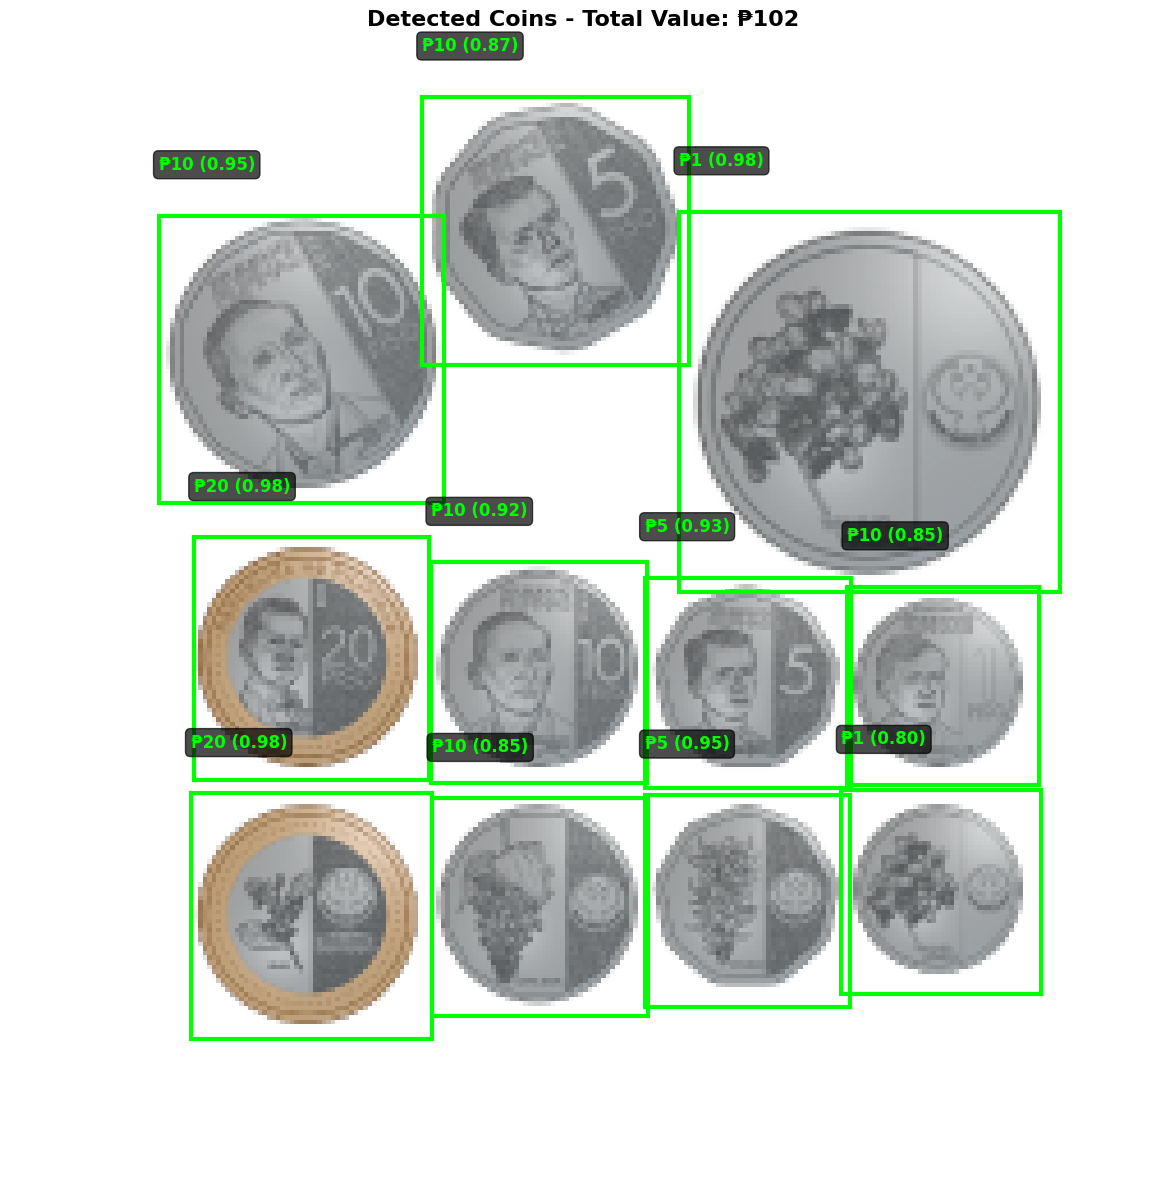


Total Value: ₱102
Number of coins detected: 11

Detailed breakdown:
  1. 01: ₱1 (confidence: 0.98)
  2. 20: ₱20 (confidence: 0.98)
  3. 20: ₱20 (confidence: 0.98)
  4. 10: ₱10 (confidence: 0.95)
  5. 05N: ₱5 (confidence: 0.95)
  6. 05N: ₱5 (confidence: 0.93)
  7. 10: ₱10 (confidence: 0.92)
  8. 10: ₱10 (confidence: 0.87)
  9. 10: ₱10 (confidence: 0.85)
  10. 10: ₱10 (confidence: 0.85)
  11. 01: ₱1 (confidence: 0.80)


In [164]:
test_custom_image(model_v2, "coins_ngsc/testings/TESTER_01.PNG")

### **6. Saving the Model**

In [ ]:
import shutil

best_model_path = Path("best_coin_detector.pt")
model_v2.save(str(best_model_path))
print(f"✅ Best model saved to: {best_model_path.absolute()}")

src = Path("runs/detect/coin_detector_v2/weights/best.pt")
if src.exists():
    shutil.copy(src, "best_coin_detector_from_training.pt")
    print(f"✅ Training best weights copied to: best_coin_detector_from_training.pt")

✅ Best model saved to: C:\Users\Lanz Railey Fermin\Desktop\projects\ma282_coins\best_coin_detector.pt
✅ Training best weights copied to: best_coin_detector_from_training.pt
